# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import random
import sys
import os

import torch
from torch import nn
from torch.utils import data

sys.path.append("../../src")
sys.path.append("../palm-tree")

import embedder
import models
import utils
import dataset

# Data

We should firstly parse the sample basic block data, or load it from pickle if the parsed data have been saved.
The preprocessing steps are based on data analysis done in the data exploration notebook

In [2]:
data_files = os.listdir("../../dataset/bb_data/")

if "good_dataset.pkl" not in data_files:
    result_files = [f for f in os.listdir("../../../good_dataset/") if f.endswith("results")] 
    #program_data_df = {}
    data_df = pd.DataFrame()

    for file in result_files:
        file_df = utils.read_bb_data(f"../../../good_dataset/{file}/breaker_code.txt", f"../../../good_dataset/{file}/breaker_final_energy.txt")
        file_df = utils.preprocess_bb_df(file_df)
        #program_data_df[file] = file_df
        data_df = pd.concat([data_df, file_df], ignore_index=True)
else:
    data_df = pd.read_pickle("../../dataset/bb_data/good_dataset.pkl")

if "bb_embeddings" not in data_df.columns:
    data_df["bb_embeddings"] = data_df.bb.apply(lambda x: embedder.encode(x))
    data_df.to_pickle("../../dataset/bb_data/good_dataset.pkl")

In [3]:
data_df.head(5)

,bb,energy,bb_embeddings
0,[movl $0x0],0.645165,"[[1.0268462, 0.028481035, 2.7335312, 0.5859081..."
1,"[callq, pushq %rbp, mov %rsp %rbp]",2.910575,"[[0.11681142, -0.7584041, 2.0799158, 0.3227231..."
2,"[popq %rbp, retq]",0.997157,"[[1.0268458, 0.028480439, 2.7335315, 0.5859076..."
3,[movl $0x0],0.664772,"[[1.0268462, 0.028481035, 2.7335312, 0.5859081..."
4,"[cmpl $0x64, jnl 0x2c]",1.400952,"[[1.0268458, 0.028480439, 2.7335315, 0.5859076..."


Pytorch custom dataset

In [4]:
split = 0.9

data_df = data_df.sample(frac=1, random_state=42).reset_index(drop=True)

bb_df_train = data_df[:int(split * len(data_df))]
bb_df_val = data_df[int(split * len(data_df)):]

In [6]:
BATCH_SIZE = 32
mean = True

train_data = dataset.EnergyPredictionDataset(bb_df_train, mean=mean)
if mean:
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
else:
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, collate_fn=utils.collate_fn)

val_data = dataset.EnergyPredictionDataset(bb_df_val, mean=mean)
if mean:
    val_loader = data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
else:
    val_loader = data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, collate_fn=utils.collate_fn)

# LSTM Model

In [6]:
class LSTM_Regressor(nn.Module):

    def __init__(self, emb_size: int, hidden_size: int = 16, num_layers: int = 2, bidirectional: bool = False) -> None:
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=0.1,
        )

        self.dense = nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(0.1)
        self.smaller_dense = nn.Linear(128, 16)
        self.regressor = nn.Linear(16, 1)

    def forward(self, x, hidden):
        
        batch_size = x.size(0)
        
        lstm_out, hidden_state = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_size)

        out = self.dense(lstm_out)
        out = self.dropout(out)
        out = self.smaller_dense(out)
        out = self.regressor(out)

        out = out.view(batch_size, -1)
        out = out[:, -1]

        return out, hidden_state

    def init_hidden(self, batch_size):

        hidden = (torch.zeros((self.num_layers, batch_size, self.hidden_size)).cuda(),
                  torch.zeros((self.num_layers, batch_size, self.hidden_size)).cuda())
        
        return hidden

In [7]:
EMBEDDING_DIM = train_data.__getitem__(0)[0][0].shape[0]
NUM_LAYERS = 10
HIDDEN_DIM = 256

model = LSTM_Regressor(emb_size=EMBEDDING_DIM, hidden_size=HIDDEN_DIM, num_layers=NUM_LAYERS)
print(model)

LSTM_Regressor(
  (lstm): LSTM(128, 256, num_layers=10, batch_first=True, dropout=0.1)
  (dense): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (smaller_dense): Linear(in_features=128, out_features=16, bias=True)
  (regressor): Linear(in_features=16, out_features=1, bias=True)
)


In [8]:
EPOCHS = 100

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-4)

model.cuda()
model.train()

cnt = 0

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    hidden_state = model.init_hidden(batch_size=BATCH_SIZE)
    losses = []
    for embeddings, _, labels in train_loader:

        embeddings = embeddings.cuda()
        labels = labels.cuda()

        hidden_state = tuple([each.data for each in hidden_state])


        output, hidden_state = model(embeddings, hidden_state)
        loss = criterion(output.squeeze(), labels.float())

        optimizer.zero_grad()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        losses.append(loss.item())

    val_h = model.init_hidden(BATCH_SIZE)
    val_loss = []
    model.eval()
    for embeddings, _, labels in val_loader:

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history

        embeddings, labels = embeddings.cuda(), labels.cuda()  
        output, val_h = model(embeddings, val_h)
        v_loss = criterion(output.squeeze(), labels.float())

        val_loss.append(v_loss.item())

    model.train()
    print(
        f"Epoch: {epoch+1}/{EPOCHS}, MSE Train Loss: {round(np.mean(losses), 5)}, MSE Val Loss: {round(np.mean(val_loss), 5)}"
    )

    train_losses.append(np.mean(losses))
    val_losses.append(np.mean(val_loss))

Epoch: 1/100, MSE Train Loss: 0.87863, MSE Val Loss: 0.91576
Epoch: 2/100, MSE Train Loss: 0.86847, MSE Val Loss: 0.91706
Epoch: 3/100, MSE Train Loss: 0.8668, MSE Val Loss: 0.91726
Epoch: 4/100, MSE Train Loss: 0.86612, MSE Val Loss: 0.91741
Epoch: 5/100, MSE Train Loss: 0.86578, MSE Val Loss: 0.91731
Epoch: 6/100, MSE Train Loss: 0.86523, MSE Val Loss: 0.9172
Epoch: 7/100, MSE Train Loss: 0.86518, MSE Val Loss: 0.91725
Epoch: 8/100, MSE Train Loss: 0.86539, MSE Val Loss: 0.91697
Epoch: 9/100, MSE Train Loss: 0.86479, MSE Val Loss: 0.91719
Epoch: 10/100, MSE Train Loss: 0.8649, MSE Val Loss: 0.91675
Epoch: 11/100, MSE Train Loss: 0.86458, MSE Val Loss: 0.9166
Epoch: 12/100, MSE Train Loss: 0.8643, MSE Val Loss: 0.91687
Epoch: 13/100, MSE Train Loss: 0.86453, MSE Val Loss: 0.91697
Epoch: 14/100, MSE Train Loss: 0.86476, MSE Val Loss: 0.91691
Epoch: 15/100, MSE Train Loss: 0.86429, MSE Val Loss: 0.91672
Epoch: 16/100, MSE Train Loss: 0.8638, MSE Val Loss: 0.91694
Epoch: 17/100, MSE Trai

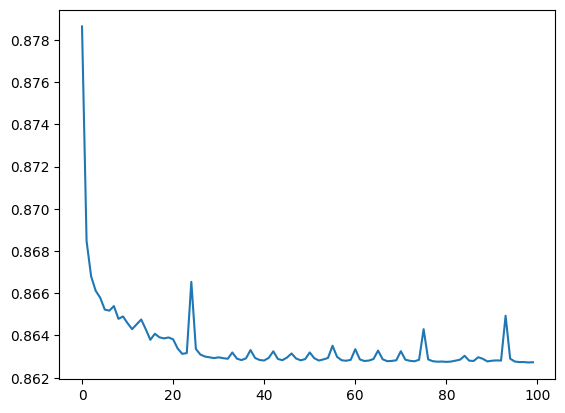

In [9]:
plt.plot(train_losses)
plt.show()

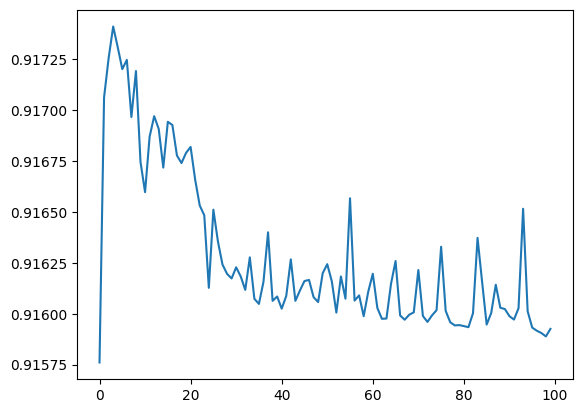

In [10]:
plt.plot(val_losses)
plt.show()

In [11]:
preds = []

val_h = model.init_hidden(BATCH_SIZE)
for embeddings, _, labels in val_loader:

    embeddings, labels = embeddings.cuda(), labels.cuda()  
    output, val_h = model(embeddings, val_h)
    preds.append(output.tolist())

preds = np.array(preds).flatten()

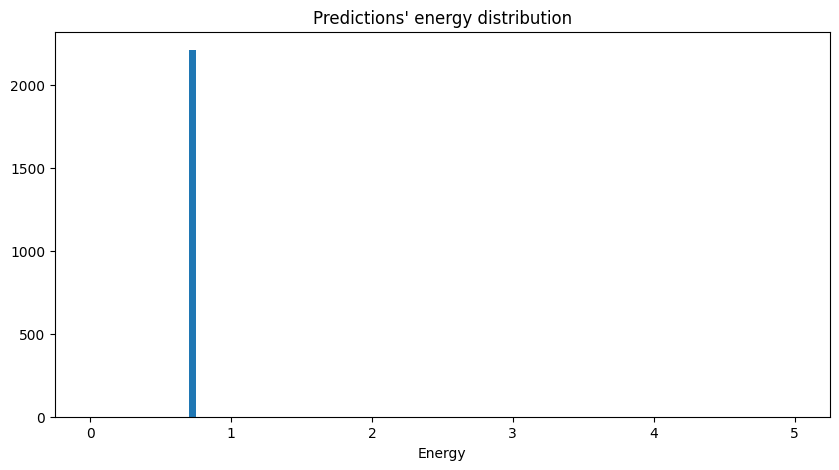

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

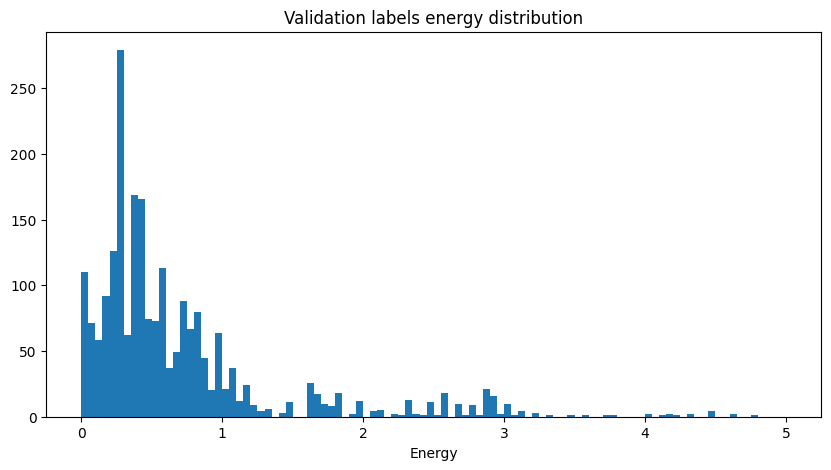

In [13]:
val_labels = bb_df_val.energy

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()

# Simple Model

In [7]:
class Simple_Regressor(nn.Module):

    def __init__(self, emb_size: int) -> None:
        super().__init__()

        self.dense = nn.Linear(emb_size, 256)
        self.dense2 = nn.Linear(256, 128)
        self.dense3 = nn.Linear(128, 64)
        self.dense4 = nn.Linear(64, 16)
        self.dense5 = nn.Linear(16, 4)
        self.dropout = nn.Dropout(0.15)
        self.dropout2 = nn.Dropout(0.05)
        self.regressor = nn.Linear(4, 1)

    def forward(self, x):
        
        out = self.dense(x)
        out = self.dropout(out)
        out = self.dense2(out)
        out = self.dropout(out)
        out = self.dense3(out)
        out = self.dropout(out)
        out = self.dense4(out)
        out = self.dropout2(out)
        out = self.dense5(out)
        out = self.regressor(out)

        return out

In [8]:
EMBEDDING_DIM = train_data.__getitem__(0)[0].shape[0]

model = Simple_Regressor(emb_size=EMBEDDING_DIM)
print(model)

Simple_Regressor(
  (dense): Linear(in_features=128, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=128, bias=True)
  (dense3): Linear(in_features=128, out_features=64, bias=True)
  (dense4): Linear(in_features=64, out_features=16, bias=True)
  (dense5): Linear(in_features=16, out_features=4, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
  (dropout2): Dropout(p=0.05, inplace=False)
  (regressor): Linear(in_features=4, out_features=1, bias=True)
)


In [9]:
EPOCHS = 500

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-4)

model.cuda()
model.train()

#cnt = 0

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    losses = []
    for embeddings, labels in train_loader:
        #cnt += 1

        embeddings = embeddings.cuda()
        labels = labels.cuda()

        output = model(embeddings)
        loss = criterion(output.squeeze(), labels.float())

        optimizer.zero_grad()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        
        losses.append(round(loss.item(), 2))

    #if cnt % 100 == 0:

    val_loss = []
    model.eval()
    for embeddings, labels in val_loader:

        embeddings, labels = embeddings.cuda(), labels.cuda()  
        output = model(embeddings)
        v_loss = criterion(output.squeeze(), labels.float())

        val_loss.append(v_loss.item())

    model.train()
    print(
        f"Epoch: {epoch+1}/{EPOCHS}, MSE Train Loss: {np.mean(losses)}, MSE Val Loss: {np.mean(val_loss)}"
    )

    train_losses.append(np.mean(losses))
    val_losses.append(np.mean(val_loss))

Epoch: 1/500, MSE Train Loss: 0.7369426751592357, MSE Val Loss: 0.6702087207332902
Epoch: 2/500, MSE Train Loss: 0.634235668789809, MSE Val Loss: 0.6491751534783322
Epoch: 3/500, MSE Train Loss: 0.6037579617834395, MSE Val Loss: 0.6472167122191277
Epoch: 4/500, MSE Train Loss: 0.5838057324840764, MSE Val Loss: 0.623615113073501
Epoch: 5/500, MSE Train Loss: 0.5763535031847133, MSE Val Loss: 0.6140937173496122
Epoch: 6/500, MSE Train Loss: 0.5640605095541401, MSE Val Loss: 0.6276457506245461
Epoch: 7/500, MSE Train Loss: 0.5549363057324841, MSE Val Loss: 0.601125465463037
Epoch: 8/500, MSE Train Loss: 0.5518630573248408, MSE Val Loss: 0.6041701390691425
Epoch: 9/500, MSE Train Loss: 0.5463216560509554, MSE Val Loss: 0.5923479851605236
Epoch: 10/500, MSE Train Loss: 0.5423089171974522, MSE Val Loss: 0.6038259403861087
Epoch: 11/500, MSE Train Loss: 0.5410350318471338, MSE Val Loss: 0.6086318131158317
Epoch: 12/500, MSE Train Loss: 0.5309076433121018, MSE Val Loss: 0.5930093595947045
Epoc

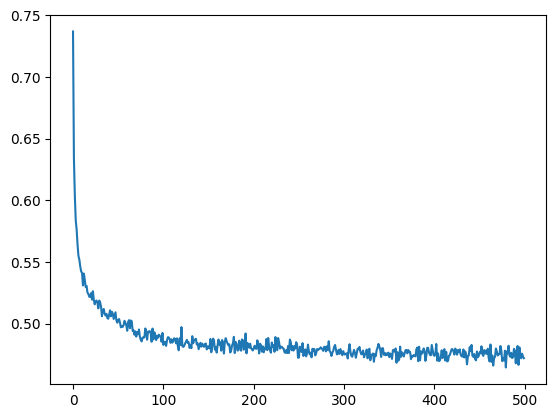

In [10]:
plt.plot(train_losses)
plt.show()

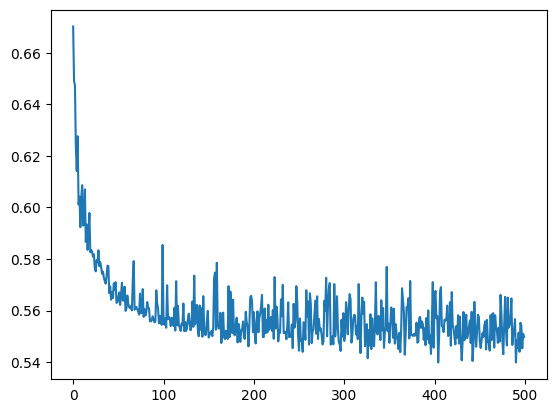

In [11]:
plt.plot(val_losses)
plt.show()

In [12]:
median = np.median(bb_df_train.energy.values)
std = np.std(bb_df_train.energy.values)

print(f"Train labels median: {median}, Train labels std: {std}")

Train labels median: 0.4922362774227444, Train labels std: 0.9288161136246514


In [13]:
median = np.median(bb_df_val.energy.values)
std = np.std(bb_df_val.energy.values)

print(f"Val labels median: {median}, Val labels std: {std}")

Val labels median: 0.4437827194929485, Val labels std: 0.958447252198232


In [14]:
preds = []

for embeddings, labels in val_loader:
    embeddings, labels = embeddings.cuda(), labels.cuda()  
    preds.append(model(embeddings).tolist())

preds = np.array(preds).flatten()

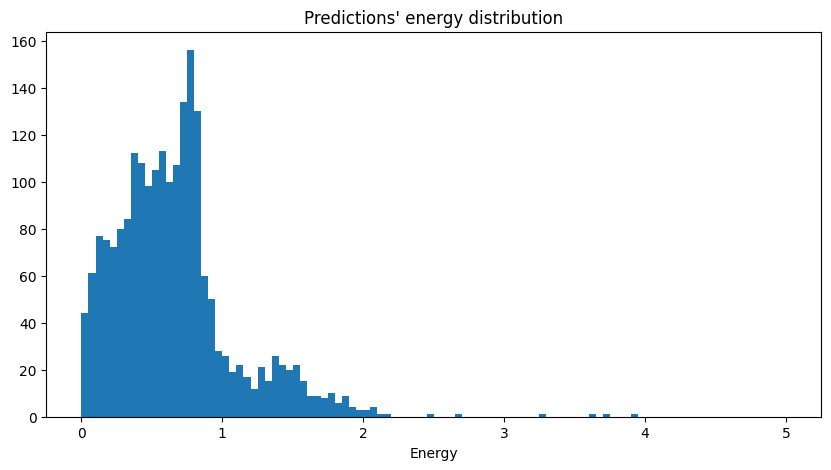

In [15]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

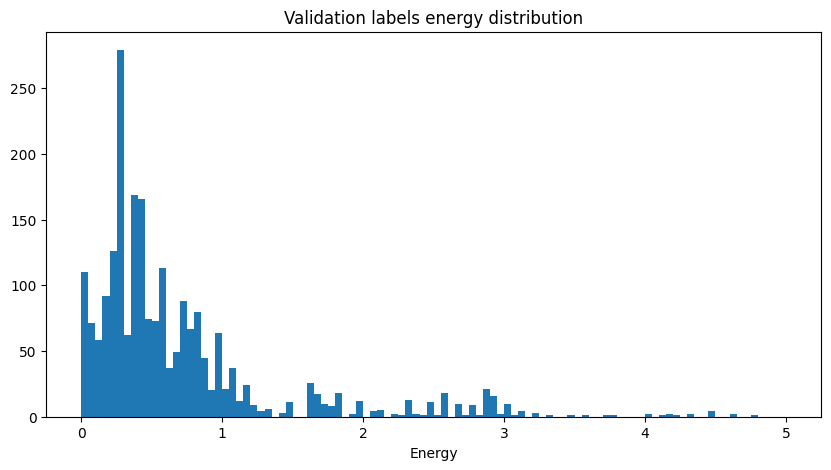

In [16]:
val_labels = bb_df_val.energy

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()